In [1]:
from pathlib import Path
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

Data Preprocessing and Analysis
This code focuses on preprocessing and combining datasets from two sources, with the end goal of preparing them for further analysis or machine learning.

Loading the Data: The code first loads two Excel files, source_1.xlsx and source_2.xlsx, which contain signals from two different sources. These files are loaded into separate dataframes (source_1_df and source_2_df) using the pandas function read_excel. The argument header=None ensures that all rows in the Excel files are treated as data, without any pre-assumed headers.

Defining Column Names: Since the signals consist of 3400 data points, a list of column names (DP-1, DP-2, ..., DP-3400) is generated. These represent the individual data points (features) for each signal.

Removing Irrelevant Columns: The code drops the first six columns from both dataframes, which likely contain irrelevant information such as timestamps or metadata. This ensures that only the useful signal data (the 3400 data points) is retained.

Renaming the Columns: After dropping the unnecessary columns, the remaining columns in both dataframes are renamed to match the list of column names (DP-1 to DP-3400), ensuring a consistent structure for the signal data.

Labeling the Data: A new column called source is added to both dataframes. This column acts as a label indicating the origin of each signal: 0 for signals from source_1 and 1 for signals from source_2. This labeling is important for classification tasks, allowing the model to distinguish between the two sources.

Combining the Datasets: The two labeled dataframes are then concatenated vertically (row-wise) to create a single unified dataframe. This merged dataframe now contains all the signals from both sources, along with their corresponding labels.

Resetting the Index: After combining the data, the index is reset to ensure it is sequential, and the old indices are dropped. This step is particularly useful to avoid any confusion from the original row numbers in the separate dataframes.

Saving the Preprocessed Data: Finally, the combined dataframe is saved as a new Excel file (dataframe.xlsx). The argument index=False ensures that the index values are not written to the file, keeping the saved data clean and ready for further analysis or machine learning applications.

In [3]:
source_1_file = Path("excel_files\source_1.xlsx")
source_2_file = Path("excel_files\source_2.xlsx")
source_1_df = pd.read_excel(source_1_file, header=None)
source_2_df = pd.read_excel(source_2_file, header=None)

column_names = [f'DP-{i}' for i in range(1, 3401)]

source_1_df = source_1_df.drop(source_1_df.columns[:6], axis=1)
source_1_df.columns = column_names
source_1_df['source'] = 0 # 0 for source 1

source_2_df = source_2_df.drop(source_2_df.columns[:6], axis=1)
source_2_df.columns = column_names
source_2_df['source'] = 1 # 1 for source 2

dataframe = pd.concat([source_1_df, source_2_df], axis=0)
dataframe = dataframe.reset_index(drop=True)
dataframe.to_excel('excel_files\dataframe.xlsx', index=False)

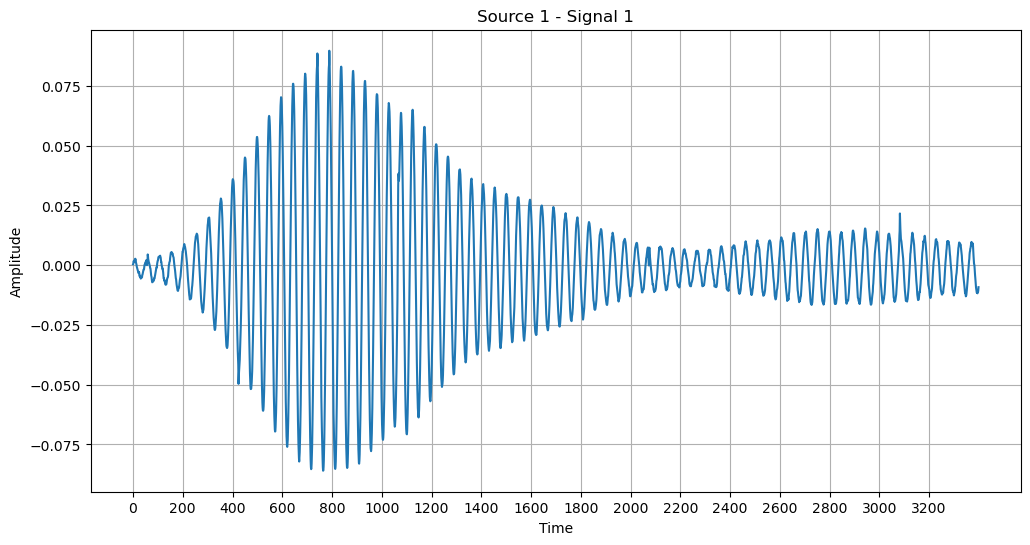

In [5]:
# Plot random signal from source 2
plt.figure(figsize=(12, 6))
plt.plot(dataframe[dataframe['source'] == 0].iloc[0, :-1])
plt.title('Source 1 - Signal 1')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(0, 3400, 200), labels=np.arange(0, 3400, 200))  # Change 200 to any interval you prefer
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

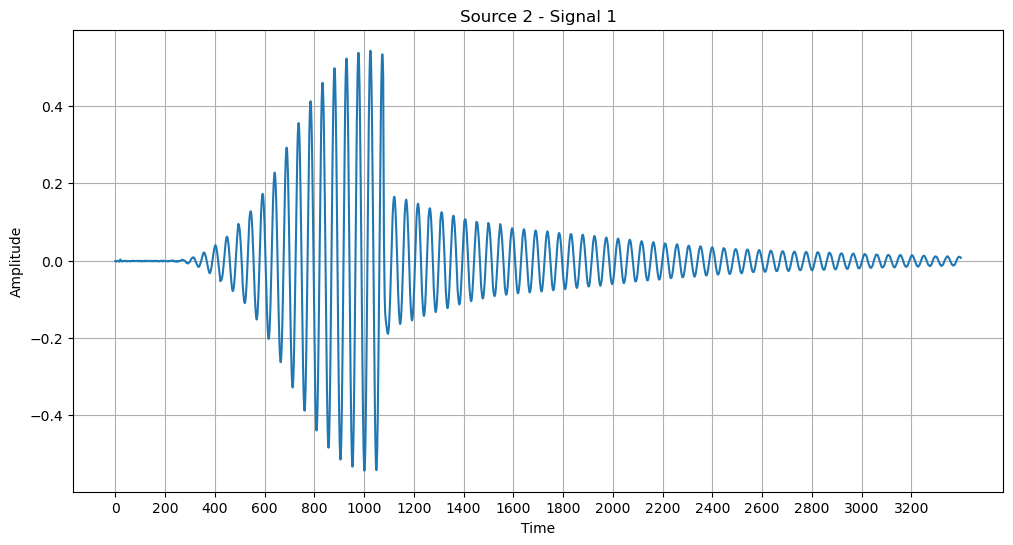

In [6]:
# Plot random signal from source 2
plt.figure(figsize=(12, 6))
plt.plot(dataframe[dataframe['source'] == 1].iloc[0, :-1])
plt.title('Source 2 - Signal 1')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(0, 3400, 200), labels=np.arange(0, 3400, 200))  # Change 200 to any interval you prefer
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

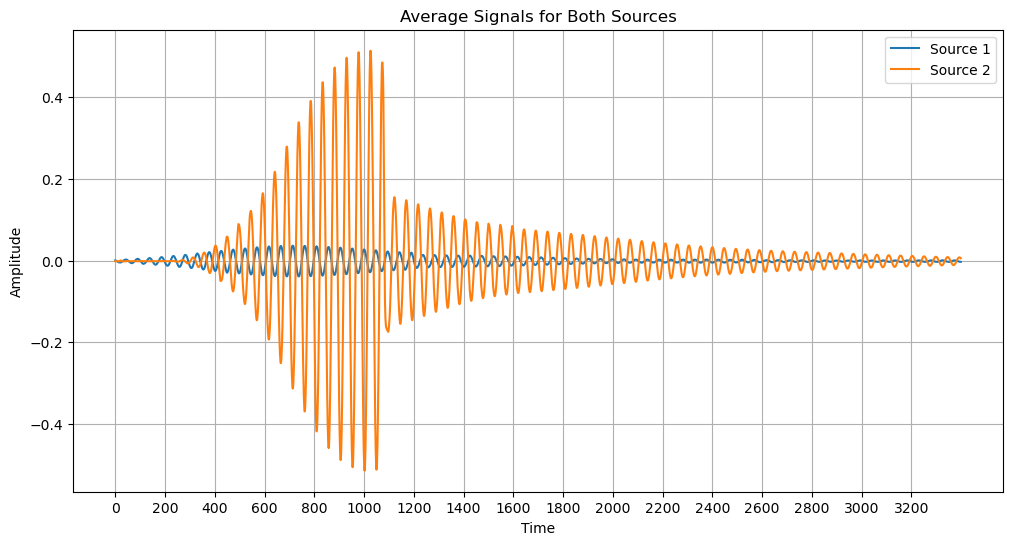

In [6]:
# Average signal for source 1
source_1_mean = dataframe[dataframe['source'] == 0].iloc[:, :-1].mean()

# Average signal for source 2
source_2_mean = dataframe[dataframe['source'] == 1].iloc[:, :-1].mean()

plt.figure(figsize=(12, 6))
plt.plot(source_1_mean, label='Source 1')
plt.plot(source_2_mean, label='Source 2')
plt.legend()
plt.title('Average Signals for Both Sources')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(0, 3400, 200), labels=np.arange(0, 3400, 200))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

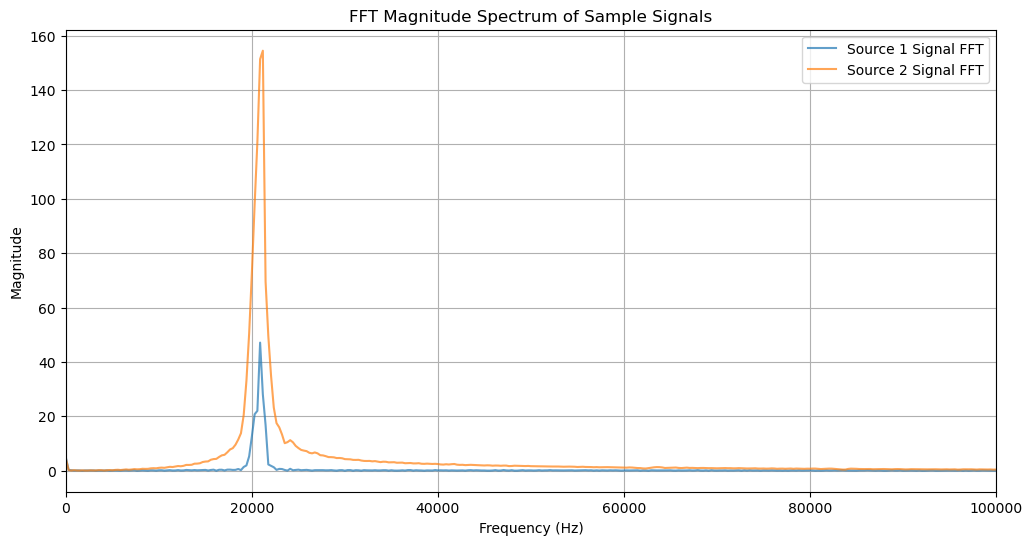

In [7]:
# Select a sample signal from each source
sample_signal_1 = dataframe[dataframe['source'] == 0].iloc[0, :-1].values
sample_signal_2 = dataframe[dataframe['source'] == 1].iloc[0, :-1].values

# Perform FFT
fft_signal_1 = np.fft.fft(sample_signal_1)
fft_signal_2 = np.fft.fft(sample_signal_2)

# Get frequency bins
n = len(sample_signal_1)  # Number of signal points
frequency = np.fft.fftfreq(n, d=1e-6)  # Sampling frequency = 1 MHz, so d = 1e-6 s

# Take the magnitude and only keep the positive frequencies
fft_magnitude_1 = np.abs(fft_signal_1)[:n//2]
fft_magnitude_2 = np.abs(fft_signal_2)[:n//2]
frequency = frequency[:n//2]
plt.figure(figsize=(12, 6))
plt.plot(frequency, fft_magnitude_1, label='Source 1 Signal FFT', alpha=0.7)
plt.plot(frequency, fft_magnitude_2, label='Source 2 Signal FFT', alpha=0.7)
plt.title('FFT Magnitude Spectrum of Sample Signals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim(0, 100000)
plt.grid()
plt.show()

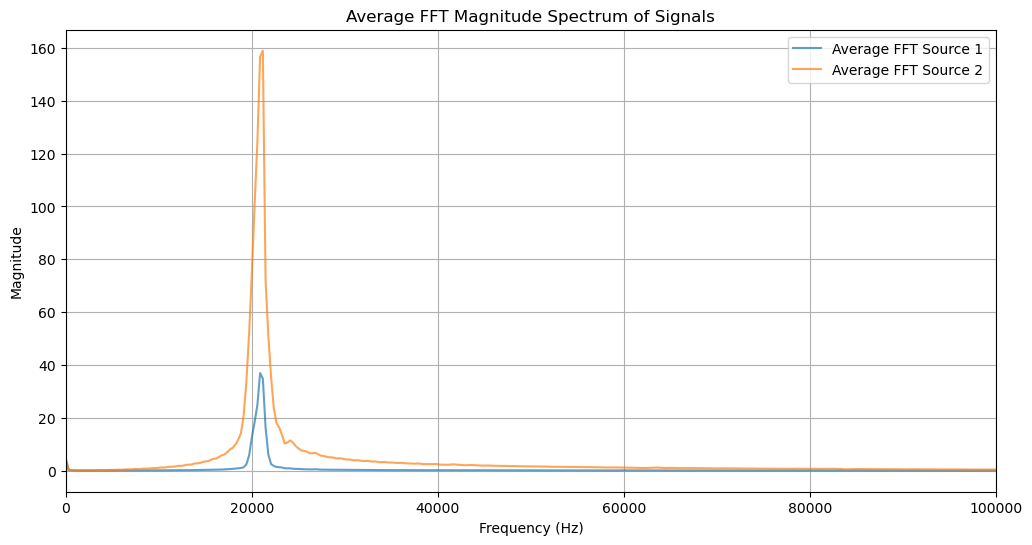

In [8]:
def average_fft(data):
    fft_results = np.abs(np.fft.fft(data, axis=1))
    avg_fft = np.mean(fft_results, axis=0)
    return avg_fft[:n//2]  # Only positive frequencies

avg_fft_source_1 = average_fft(dataframe[dataframe['source'] == 0].iloc[:, :-1].values)
avg_fft_source_2 = average_fft(dataframe[dataframe['source'] == 1].iloc[:, :-1].values)

# Plot average FFT results
plt.figure(figsize=(12, 6))
plt.plot(frequency, avg_fft_source_1, label='Average FFT Source 1', alpha=0.7)
plt.plot(frequency, avg_fft_source_2, label='Average FFT Source 2', alpha=0.7)
plt.title('Average FFT Magnitude Spectrum of Signals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim(0, 100000)
plt.grid()
plt.show()

In the exploratory data analysis (EDA), it is evident that signals from source 2 exhibit significantly higher amplitudes compared to those from source 1. This is observable both in the time domain, where the average signal for source 2 consistently shows higher values across all datapoints, and in the frequency domain, where the Fast Fourier Transform (FFT) response of source 2 signals displays stronger magnitudes across a broad range of frequencies. This suggests that source 2 contains more energetic or high-amplitude components, potentially corresponding to distinct signal characteristics or patterns that differ from source 1. These differences in amplitude and frequency content could serve as important features for classification in subsequent modeling stages.

In [9]:
Y = dataframe['source'].to_numpy()
X = dataframe.drop(columns=['source']).to_numpy()
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Reshape the data for the Neural Network Model
X_train = X_train.reshape(X_train.shape[0], 3400, 1)
X_test = X_test.reshape(X_test.shape[0], 3400, 1)

Converting the source column of the dataframe into a NumPy array Y, which contains the labels (0 or 1 for each signal source). The features X are obtained by dropping the source column and converting the remaining 3400 data points for each signal into a NumPy array.

Next, the data is split into training and test sets using train_test_split, with 70% of the data used for training and 30% for testing. The stratify option ensures that the proportion of source labels is consistent in both sets, and random_state=42 makes the split reproducible.

Finally, both X_train and X_test are reshaped into 3D arrays (samples, 3400 timesteps, 1 feature per timestep) to prepare them for use in a neural network model that expects time-series data.

In [10]:
def display_model_metrices(model, X_test, Y_test):
    # Get predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(Y_test, y_pred)
    
    # Confusion matrix and its components
    conf_matrix = confusion_matrix(Y_test, y_pred)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    
    # Classification report
    class_report = classification_report(Y_test, y_pred, output_dict=True)
    precision = class_report['1']['precision']
    recall = class_report['1']['recall']
    f1_score = class_report['1']['f1-score']
    
    # Print results in a better format
    print(f"\n{'Model Evaluation Metrics':^40}")
    print("-" * 40)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    print("\nConfusion Matrix:")
    print(f"True Positives (TP): {TP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    
    print("\nClassification Report Metrics (for Class 1):")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1_score * 100:.2f}%")

In [11]:
def plot_model_metrices(model_name, model_history):

    output_dir = Path('model_metrices_plots')
    if not output_dir.exists():
        output_dir.mkdir()

    # Plot training & validation accuracy values
    plt.plot(model_history['accuracy'])
    plt.plot(model_history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'{output_dir}/{model_name}_accuracy.png')
    plt.show()

    # Plot training & validation loss values
    plt.plot(model_history['loss'])
    plt.plot(model_history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'{output_dir}/{model_name}_loss.png')
    plt.show()

In [12]:
# Build the CNN model
cnn_model = Sequential()

cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(3400, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu'))

# Output layer for binary classification
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3396, 64)          384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1698, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1694, 128)         41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 847, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 843, 256)          164096    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 421, 256)         0

1D Convolutional Neural Network (CNN) model using TensorFlow's Keras API, designed for binary classification tasks. Here's a breakdown of the model:

1. Model Structure:
Sequential API: The model is constructed using the Sequential class, which allows stacking layers linearly, from input to output.
2. Convolutional Layers:
First Conv1D Layer: The model begins with a 1D Convolutional layer (Conv1D) that applies 64 filters of size 5 across the input data. This layer extracts features from the input data of shape (3400, 1) (which could be a time series or sequential data with 3400 steps and 1 feature per step). The ReLU activation function introduces non-linearity.

MaxPooling1D: Following the convolution, a Max Pooling layer reduces the dimensionality by taking the maximum value from each pool of size 2. This helps in reducing the computational cost and controlling overfitting.

Second Conv1D Layer: Another Conv1D layer with 128 filters and a kernel size of 5 is added, followed by a Max Pooling layer. This layer captures more complex patterns.

Third Conv1D Layer: A third Conv1D layer with 256 filters is used, followed by Max Pooling. This layer captures even deeper features.

3. Flattening Layer:
After the convolutional layers, a Flatten layer converts the 3D tensor (resulting from the convolutional layers) into a 1D vector, making it suitable for fully connected layers.
4. Fully Connected Layers:
Dense Layer 1: A dense (fully connected) layer with 128 neurons and ReLU activation is added. This layer interprets the features extracted by the convolutional layers.
Dropout Layer: A dropout layer with a rate of 0.5 is added to reduce overfitting by randomly setting half of the input units to zero during training.
Dense Layer 2: Another dense layer with 64 neurons and ReLU activation is added to further refine the learned features.
5. Output Layer:
Dense Layer (Output): The final layer is a dense layer with 1 neuron and a sigmoid activation function, suitable for binary classification. The sigmoid function outputs a probability value between 0 and 1.
6. Compilation:
The model is compiled with the Adam optimizer (learning rate set to 0.0001), using binary cross-entropy as the loss function (suitable for binary classification tasks), and accuracy as the performance metric.
7. Model Summary:
The cnn_model.summary() function call outputs a summary of the model architecture, including the number of parameters in each layer and the overall structure.

In [13]:
cnn_history = cnn_model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
4/4 [==============================] - 4s 472ms/step - loss: 0.6644 - accuracy: 0.5536 - val_loss: 0.6467 - val_accuracy: 0.3571
Epoch 2/20
4/4 [==============================] - 2s 405ms/step - loss: 0.5798 - accuracy: 0.5536 - val_loss: 0.6000 - val_accuracy: 0.4286
Epoch 3/20
4/4 [==============================] - 2s 421ms/step - loss: 0.4983 - accuracy: 0.5893 - val_loss: 0.5623 - val_accuracy: 0.4286
Epoch 4/20
4/4 [==============================] - 2s 457ms/step - loss: 0.4346 - accuracy: 0.7321 - val_loss: 0.5284 - val_accuracy: 0.6429
Epoch 5/20
4/4 [==============================] - 2s 404ms/step - loss: 0.3882 - accuracy: 0.7857 - val_loss: 0.4812 - val_accuracy: 0.7857
Epoch 6/20
4/4 [==============================] - 2s 393ms/step - loss: 0.3405 - accuracy: 0.8750 - val_loss: 0.4084 - val_accuracy: 0.8571
Epoch 7/20
4/4 [==============================] - 2s 456ms/step - loss: 0.2953 - accuracy: 0.9286 - val_loss: 0.2977 - val_accuracy: 0.8571
Epoch 8/20
4/4 [====

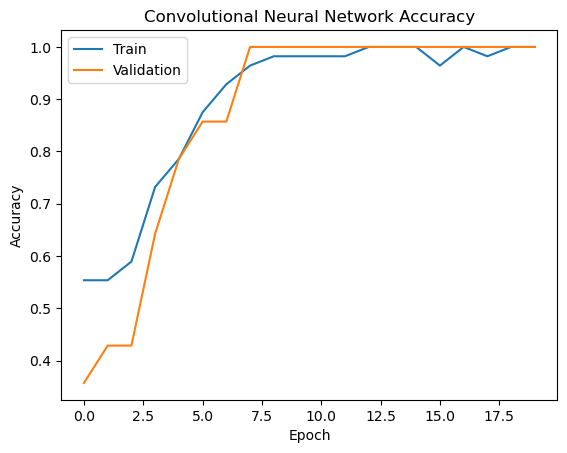

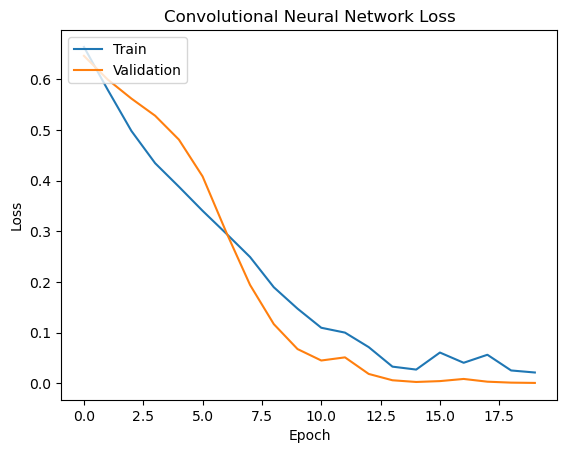

In [14]:
plot_model_metrices("Convolutional Neural Network", cnn_history.history)

In [15]:
display_model_metrices(cnn_model, X_test, Y_test)

1/1 [==============================] - 0s 246ms/step

        Model Evaluation Metrics        
----------------------------------------
Test Accuracy: 100.00%

Confusion Matrix:
True Positives (TP): 15
True Negatives (TN): 15
False Positives (FP): 0
False Negatives (FN): 0

Classification Report Metrics (for Class 1):
Precision: 100.00%
Recall: 100.00%
F1-Score: 100.00%


In [16]:
# Build the DNN model
dnn_model = Sequential()

# Flatten the input signal
dnn_model.add(Flatten(input_shape=(3400, 1)))

# First fully connected layer
dnn_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.4))

# Second fully connected layer
dnn_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.4))

# Third fully connected layer
dnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.3))

# Fourth fully connected layer
dnn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.3))

# Output layer for binary classification
dnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=['accuracy'])

1. Input Layer and Flattening:
Flatten(input_shape=(3400, 1)):
The input layer takes in a 1D signal with 3400 time steps and 1 feature per step.
The Flatten layer converts the 2D input (3400, 1) into a 1D vector of length 3400. This transformation is necessary to connect the input data to the dense layers.
2. Fully Connected Layers (Dense Layers):
The dense layers form the core of the model, capturing patterns and relationships in the data.

First Dense Layer:

Dense(512, activation='relu', kernel_regularizer=l2(0.001)):
This layer has 512 neurons, which gives the model the capacity to learn more complex patterns. The ReLU (Rectified Linear Unit) activation function introduces non-linearity, allowing the model to capture non-linear relationships in the data.
L2 regularization (kernel_regularizer=l2(0.001)) penalizes large weights during training, helping to reduce overfitting. The regularization term is added to the loss function, discouraging the model from relying too heavily on any single feature.
BatchNormalization():
Batch normalization normalizes the inputs to this layer across the batch, stabilizing and speeding up the training process. It helps mitigate the internal covariate shift (i.e., changes in the distribution of layer inputs), which can improve generalization and reduce sensitivity to weight initialization.
Dropout(0.4):
Dropout randomly sets 40% of the neurons to zero during training, preventing the model from overfitting by ensuring it doesn't rely too heavily on any particular neuron.
Second Dense Layer:

Dense(256, activation='relu', kernel_regularizer=l2(0.001)):
This layer has 256 neurons, and it continues to extract features from the data. The L2 regularization and ReLU activation functions are applied here as well.
BatchNormalization() and Dropout(0.4) are used to improve training stability and reduce overfitting.
Third Dense Layer:

Dense(128, activation='relu', kernel_regularizer=l2(0.001)):
With 128 neurons, this layer reduces the dimensionality of the feature space while retaining important information. The same techniques (ReLU, L2 regularization, batch normalization, and dropout) are applied.
Dropout(0.3): The dropout rate is slightly reduced here, as the model begins to refine its understanding of the data.
Fourth Dense Layer:

Dense(64, activation='relu', kernel_regularizer=l2(0.001)):
This layer with 64 neurons further refines the features extracted from the input data. The ReLU activation and L2 regularization are applied, along with batch normalization and a dropout rate of 30%.
3. Output Layer:
Dense(1, activation='sigmoid'):
The output layer consists of a single neuron with a sigmoid activation function. The sigmoid function maps the output to a value between 0 and 1, which is perfect for binary classification tasks (e.g., classifying the signal as belonging to one of two classes).
4. Model Compilation:
Optimizer: The model is compiled with the Adam optimizer, which is an adaptive learning rate optimization algorithm that is widely used in deep learning due to its efficiency and effectiveness.
Learning Rate: The learning rate is set to 0.0001, a small value that allows the model to learn gradually and avoid large oscillations during training.
Loss Function: The binary cross-entropy loss function is used, which is appropriate for binary classification tasks. It measures the difference between the predicted probabilities and the actual labels.
Metrics: The model's performance is evaluated using the accuracy metric.
5. Early Stopping:
EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True):
Early stopping is a technique that monitors the validation loss during training. If the validation loss stops improving for 5 consecutive epochs (i.e., no improvement within the patience period), the training process is halted.
Additionally, restore_best_weights=True ensures that the model's weights are rolled back to the state where validation loss was the lowest, preventing overfitting.

In [17]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the Dnn model
dnn_history = dnn_model.fit(X_train, Y_train, validation_split=0.2, epochs=150, batch_size=32, callbacks=[early_stopping])

Epoch 1/150
2/2 [==============================] - 3s 528ms/step - loss: 2.2780 - accuracy: 0.6250 - val_loss: 2.1696 - val_accuracy: 0.5000
Epoch 2/150
2/2 [==============================] - 0s 104ms/step - loss: 2.2028 - accuracy: 0.6429 - val_loss: 2.1585 - val_accuracy: 0.7857
Epoch 3/150
2/2 [==============================] - 0s 96ms/step - loss: 2.1430 - accuracy: 0.7321 - val_loss: 2.1498 - val_accuracy: 0.7857
Epoch 4/150
2/2 [==============================] - 0s 93ms/step - loss: 1.8219 - accuracy: 0.8571 - val_loss: 2.1383 - val_accuracy: 0.7857
Epoch 5/150
2/2 [==============================] - 0s 92ms/step - loss: 1.9810 - accuracy: 0.7857 - val_loss: 2.1269 - val_accuracy: 0.8571
Epoch 6/150
2/2 [==============================] - 0s 58ms/step - loss: 1.8576 - accuracy: 0.8571 - val_loss: 2.1167 - val_accuracy: 0.8571
Epoch 7/150
2/2 [==============================] - 0s 58ms/step - loss: 1.7545 - accuracy: 0.8750 - val_loss: 2.1061 - val_accuracy: 0.8571
Epoch 8/150
2/2 [=

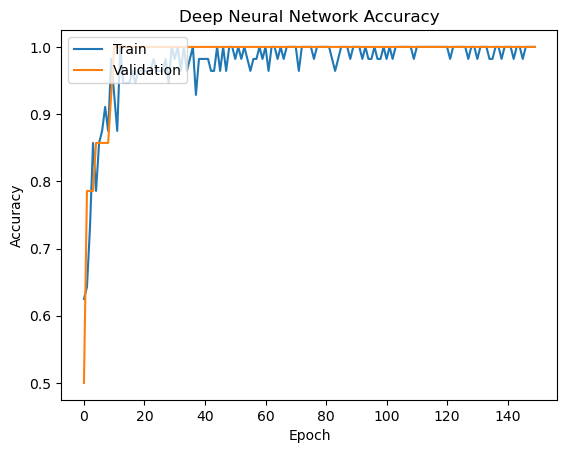

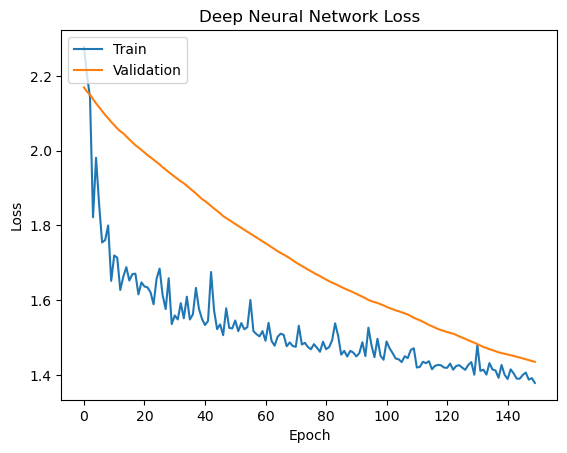

In [18]:
plot_model_metrices("Deep Neural Network", dnn_history.history)

In [19]:
display_model_metrices(dnn_model, X_test, Y_test)

1/1 [==============================] - 0s 135ms/step

        Model Evaluation Metrics        
----------------------------------------
Test Accuracy: 100.00%

Confusion Matrix:
True Positives (TP): 15
True Negatives (TN): 15
False Positives (FP): 0
False Negatives (FN): 0

Classification Report Metrics (for Class 1):
Precision: 100.00%
Recall: 100.00%
F1-Score: 100.00%


In [ ]:
# Build the LSTM model
lstm_model = Sequential()

# LSTM layers
lstm_model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(BatchNormalization())

# Fully connected layer
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.3))

# Output layer for binary classification
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='binary_crossentropy', metrics=['accuracy'])

The LSTM model is designed to classify time-series data into two distinct categories effectively. The architecture begins with a series of three LSTM layers, which are specialized for learning patterns in sequences of data. The first LSTM layer features 128 units, enabling it to output a sequence of 128 features for each timestep of the input data. By setting return_sequences=True, this layer ensures that the entire output sequence is fed into the next layer, which is essential for maintaining temporal information in the data as it progresses through the network. To enhance generalization and prevent overfitting, both dropout and recurrent dropout rates are set to 20%. This means that during training, 20% of the units in the LSTM layer are randomly ignored, which helps the model avoid relying too heavily on any single feature.

Following the first LSTM layer, a batch normalization layer is added. This layer normalizes the outputs of the previous LSTM, helping to stabilize the learning process and accelerate convergence during training. The second LSTM layer, which contains 64 units, also outputs a sequence, further refining the model's ability to capture complex patterns in the data. It is followed by another batch normalization layer, continuing to ensure stable training.

The third LSTM layer is slightly different, containing 32 units and configured without the return_sequences parameter, which means it only outputs the final output for each input sequence instead of a full sequence. This is designed to condense the learned features before they are passed to the dense layers. After the LSTM layers, the model incorporates a fully connected (dense) layer with 64 units. This layer uses the ReLU activation function, which introduces non-linearity to the model, allowing it to learn more complex relationships within the data. A dropout rate of 30% is applied in this layer as well, which means that during training, 30% of the neurons will be ignored to prevent overfitting.

The output layer of the model consists of a single neuron with a sigmoid activation function, producing an output between 0 and 1. This output can be interpreted as the probability that a given input sequence belongs to one of the two classes, making it suitable for binary classification tasks.

Finally, the model is compiled using the Adam optimizer, which is known for its efficient handling of large datasets and its capability to adaptively adjust learning rates during training. The learning rate is set to 0.0001, which is relatively low and helps ensure smooth convergence without overshooting the optimal solution. The binary crossentropy loss function is utilized to measure how well the predicted probabilities align with the true labels, which is ideal for binary classification problems. Additionally, accuracy is tracked as a performance metric, allowing the evaluation of how well the model performs on the classification task throughout training. Overall, this LSTM model is robustly designed to capture the temporal dynamics of time-series data while incorporating regularization techniques to enhance generalization and performance.

In [ ]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = lstm_model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

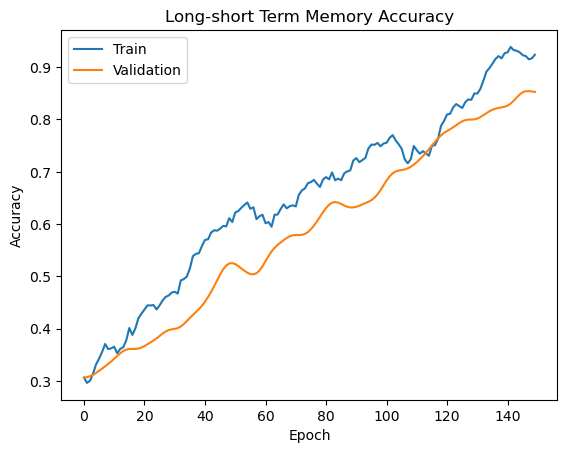

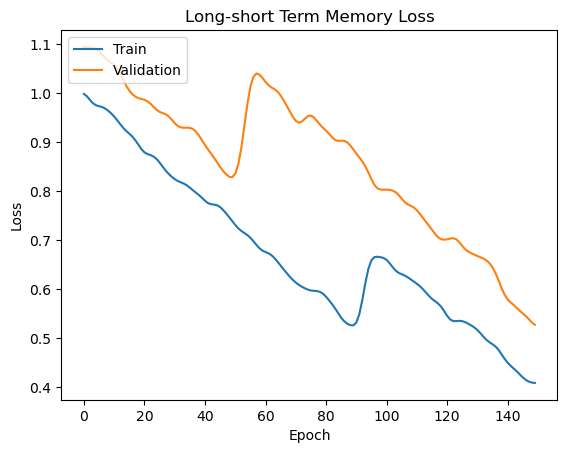

In [20]:
plot_model_metrices("Deep Neural Network", lstm_model.history)

In [2]:
display_model_metrices(lstm_model, X_test, Y_test)


        Model Evaluation Metrics        
----------------------------------------
Test Accuracy: 80.00%

Confusion Matrix:
True Positives (TP): 6
True Negatives (TN): 6
False Positives (FP): 2
False Negatives (FN): 1

Classification Report Metrics (for Class 1):
Precision: 75.00%
Recall: 85.71%
F1-Score: 80.00%
